In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install transformers datasets
!pip install transformers
!pip install datasets
!pip install accelerate
!pip install easyocr
# Cài đặt OpenAI Whisper và thư viện hỗ trợ
!pip install -q git+https://github.com/openai/whisper.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 14.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import pandas as pd
import re
import time
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from transformers import AutoTokenizer, AutoProcessor, AutoModelForCTC, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset
import numpy as np
import torch
from torch import nn
import librosa
import gradio as gr
import easyocr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import json, os

In [ ]:
import pandas as pd
import numpy as np
import random
import unicodedata
import re

# Load data
df = pd.read_csv('/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/ViCTSD_train.csv')

# --- Augmentation Helpers ---

def remove_accents(input_str):
    if not isinstance(input_str, str): return str(input_str)
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return "".join([c for c in nfkd_form if not unicodedata.combining(c)])

teencode_dict = {
    r'\bkhông\b': 'k', r'\bkhong\b': 'k', r'\bko\b': 'k',
    r'\bđược\b': 'dc', r'\bduoc\b': 'dc',
    r'\bgì\b': 'j', r'\bgi\b': 'j',
    r'\bquá\b': 'qa', r'\bqua\b': 'qa',
    r'\bngười\b': 'ng', r'\bnguoi\b': 'ng',
    r'\bnhiều\b': 'nh', r'\bnhieu\b': 'nh',
    r'\bviệt nam\b': 'vn', r'\bviet nam\b': 'vn',
    r'\btại sao\b': 'ti shao',
    r'\bchồng\b': 'ck', r'\bvợ\b': 'vk',
    r'\bbuồn\b': 'buon',
    r'\bđang\b': 'dg',
    r'\bnhư\b': 'nhu',
    r'\bthôi\b': 'thoi',
    r'\bmày\b': 'm', r'\btao\b': 't', # adding some common aggressive pronouns often used in toxic speech
    r'\bchửi\b': 'chui',
}

def apply_teencode(text):
    if not isinstance(text, str): return ""
    new_text = text.lower()
    for pattern, replacement in teencode_dict.items():
        if random.random() < 0.5:
            new_text = re.sub(pattern, replacement, new_text)
    return new_text

def random_deletion(text, p=0.15):
    if not isinstance(text, str): return ""
    words = text.split()
    if len(words) <= 1: return text
    remaining = [w for w in words if random.random() > p]
    if len(remaining) == 0: return words[random.randint(0, len(words)-1)]
    return ' '.join(remaining)

def random_swap(text, n=1):
    if not isinstance(text, str): return ""
    words = text.split()
    length = len(words)
    if length < 2: return text
    for _ in range(n):
        idx1, idx2 = random.randint(0, length-1), random.randint(0, length-1)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def mix_comments(text1, text2):
    # Combine first half of text1 and second half of text2
    words1 = text1.split()
    words2 = text2.split()
    if not words1 or not words2: return text1

    mid1 = len(words1) // 2
    mid2 = len(words2) // 2

    new_words = words1[:mid1] + words2[mid2:]
    return ' '.join(new_words)

def augment_sentence(text, text_pair=None, type='general'):
    # text_pair is for mixing
    if type == 'toxic' and text_pair and random.random() < 0.3: # 30% chance to mix if toxic
        return mix_comments(text, text_pair)

    choice = random.choice(['accents', 'teencode', 'delete', 'swap', 'accents_teencode'])
    if choice == 'accents': return remove_accents(text)
    elif choice == 'teencode': return apply_teencode(text)
    elif choice == 'delete': return random_deletion(text)
    elif choice == 'swap': return random_swap(text)
    elif choice == 'accents_teencode': return apply_teencode(remove_accents(text))
    return text

# --- Main Logic ---

df_toxic = df[df['Toxicity'] == 1].reset_index(drop=True)
df_clean = df[df['Toxicity'] == 0].reset_index(drop=True)

# Target: Add 15k rows total. Let's aim for ~11k Toxic total and ~11k Clean total (22k total)
# Current: 759 Toxic, 6241 Clean
target_toxic_count = 11000
target_clean_count = 11000

new_rows = []

# 1. Augment Toxic
# We need ~10250 new toxic rows
toxic_comments = df_toxic['Comment'].tolist()
current_toxic = 0
needed_toxic = target_toxic_count - len(df_toxic)

while current_toxic < needed_toxic:
    # Pick random source
    idx = random.randint(0, len(df_toxic)-1)
    src_row = df_toxic.iloc[idx]
    text = src_row['Comment']

    # Pick a pair for potential mixing
    idx2 = random.randint(0, len(df_toxic)-1)
    text2 = df_toxic.iloc[idx2]['Comment']

    new_text = augment_sentence(text, text2, type='toxic')

    # Simple dedup
    if new_text != text:
        row = src_row.copy()
        row['Comment'] = new_text
        new_rows.append(row)
        current_toxic += 1

# 2. Augment Clean
# We need ~4760 new clean rows
needed_clean = target_clean_count - len(df_clean)
clean_comments = df_clean['Comment'].tolist()
current_clean = 0

while current_clean < needed_clean:
    idx = random.randint(0, len(df_clean)-1)
    src_row = df_clean.iloc[idx]
    text = src_row['Comment']

    new_text = augment_sentence(text, type='clean')

    if new_text != text:
        row = src_row.copy()
        row['Comment'] = new_text
        new_rows.append(row)
        current_clean += 1

# Combine
df_new = pd.DataFrame(new_rows)
df_combined = pd.concat([df, df_new], ignore_index=True)

# Shuffle thoroughly
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)

# Cleanup
if 'Unnamed: 0' in df_combined.columns:
    df_combined.drop(columns=['Unnamed: 0'], inplace=True)

print("Final Shape:", df_combined.shape)
print(df_combined['Toxicity'].value_counts())
df_combined.to_csv('ViCTSD_augmented_final.csv', index=False)

Final Shape: (22000, 5)
Toxicity
1    11000
0    11000
Name: count, dtype: int64


In [4]:
# ĐƯỜNG DẪN ĐẾN THƯ MỤC CHỨA 3 FILE CSV
base_dir = '/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD'

# Tên các file
train_file = 'ViCTSD_augmented_final.csv'
valid_file = 'ViCTSD_valid.csv'
test_file = 'ViCTSD_test.csv'

PHOBERT_MODEL = "vinai/phobert-base"
tokenizer = AutoTokenizer.from_pretrained(PHOBERT_MODEL)
print(f"✅ PhoBERT Tokenizer ({PHOBERT_MODEL}) đã được tải.")

# 3. ĐỊNH NGHĨA HÀM TIỀN XỬ LÝ VÀ TOKEN HÓA
def basic_cleanup(text):
    """Làm sạch cơ bản (thay thế Tách từ VnCoreNLP)."""
    text = str(text)
    text = re.sub(r'[^\w\s]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def load_and_tokenize_data_direct(filename, base_dir, tokenizer):
    """Đọc file, làm sạch và Token hóa trực tiếp."""
    file_path = os.path.join(base_dir, filename)
    print(f"\n--- Xử lý file: {filename} ---")

    if not os.path.exists(file_path):
        print(f"❌ LỖI: Không tìm thấy file tại {file_path}. Bỏ qua.")
        return None

    df = pd.read_csv(file_path)
    df_clean = df[['Comment', 'Toxicity']].copy()
    df_clean.rename(columns={'Comment': 'text', 'Toxicity': 'label'}, inplace=True)

    # Làm sạch văn bản
    df_clean['text'] = df_clean['text'].apply(basic_cleanup)

    # Chuyển đổi sang HuggingFace Dataset
    dataset = Dataset.from_pandas(df_clean[['text', 'label']])

    # Áp dụng Tokenization TRỰC TIẾP
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    tokenized_dataset = dataset.map(tokenize_function, batched=True)
    tokenized_dataset = tokenized_dataset.remove_columns(["text"]) # Xóa cột văn bản thô

    print(f"✅ Hoàn thành. Kích thước dataset: {len(tokenized_dataset)}")
    return tokenized_dataset

# 4. THỰC HIỆN TẢI VÀ TOKEN HÓA
train_tokenized = load_and_tokenize_data_direct(train_file, base_dir, tokenizer)
val_tokenized = load_and_tokenize_data_direct(valid_file, base_dir, tokenizer)
test_tokenized = load_and_tokenize_data_direct(test_file, base_dir, tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

✅ PhoBERT Tokenizer (vinai/phobert-base) đã được tải.

--- Xử lý file: ViCTSD_augmented_final.csv ---


Map:   0%|          | 0/22000 [00:00<?, ? examples/s]

✅ Hoàn thành. Kích thước dataset: 22000

--- Xử lý file: ViCTSD_valid.csv ---


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ Hoàn thành. Kích thước dataset: 2000

--- Xử lý file: ViCTSD_test.csv ---


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Hoàn thành. Kích thước dataset: 1000


In [5]:
# --- HÀM TÔ MÀU VÀ DANH SÁCH TỪ ĐỘC HẠI ---
# Danh sách mẫu: Cần được mở rộng dựa trên phân tích dữ liệu ViCTSD
TOXIC_WORDS = set([
    'ngu dốt', 'cút', 'chó', 'điên', 'óc chó', 'rác rưởi', 'khùng',
    'mày', 'tao', 'đồ ngu', 'mất dạy', 'chết đi', 'thằng', 'con'
])

def highlight_toxic_words(text):
    """Tô màu đỏ các từ/cụm từ độc hại trong văn bản và trả về chuỗi HTML."""
    if not text:
        return ""

    highlighted_text = text

    # Sắp xếp từ độc hại theo độ dài giảm dần để cụm từ dài được ưu tiên
    sorted_words = sorted(list(TOXIC_WORDS), key=len, reverse=True)

    for word in sorted_words:
        # Dùng re.escape để xử lý các ký tự đặc biệt trong từ độc hại
        # Dùng r'\b(' + word + r')\b' để đảm bảo tìm thấy toàn bộ từ (word boundaries)
        pattern = r'\b(' + re.escape(word) + r')\b'

        # Tô màu đỏ đậm bằng thẻ HTML
        highlighted_text = re.sub(
            pattern,
            r'<span style="color:red; font-weight:bold;">\1</span>',
            highlighted_text,
            flags=re.IGNORECASE
        )

    return highlighted_text

# --- HÀM OCR VÀ PHÂN LOẠI HÌNH ẢNH ---
def ocr_and_predict(image_file, tokenizer, model, reader):
    """Thực hiện OCR trên ảnh và phân loại văn bản trích xuất."""
    ocr_text = ""
    is_toxic = 0
    confidence = 0.5

    if image_file is not None and reader is not None:
        try:
            # 1. Thực hiện OCR
            results = reader.readtext(image_file)

            # 2. Nối tất cả văn bản trích xuất thành một chuỗi
            if results:
                # res[1] là văn bản trích xuất
                ocr_text = " ".join([res[1] for res in results])

            # 3. Phân loại HSD
            if ocr_text:
                # classify_text_toxicity cần được định nghĩa trước
                is_toxic, confidence = classify_text_toxicity(ocr_text, tokenizer, model)

        except Exception as e:
            ocr_text = f"❌ LỖI OCR: {e}"
            is_toxic = 0
            confidence = 0.5

    return ocr_text, is_toxic, confidence

# Thực nghiệm baseline model

Train shape: (22000, 5)
Test shape: (1000, 6)
Valid shape: (2000, 6)

Columns: ['Comment', 'Constructiveness', 'Toxicity', 'Title', 'Topic']

Label distribution (train):
 0    11000
1    11000
Name: count, dtype: int64

Label distribution (test):
 0    890
1    110
Name: count, dtype: int64

Label distribution (valid):
 Toxicity
0    1768
1     232
Name: count, dtype: int64


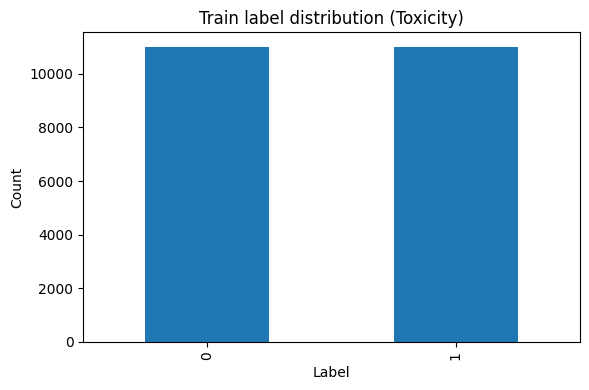


Fitting TF-IDF on train...
TF-IDF shapes: (22000, 10000) (1000, 10000)

Training MultinomialNB...
NB Accuracy: 0.8610 | Time: 0.02s
              precision    recall  f1-score   support

           0     0.9253    0.9180    0.9216       890
           1     0.3761    0.4000    0.3877       110

    accuracy                         0.8610      1000
   macro avg     0.6507    0.6590    0.6546      1000
weighted avg     0.8648    0.8610    0.8629      1000


Training LogisticRegression...
LR Accuracy: 0.8480 | Time: 0.63s
              precision    recall  f1-score   support

           0     0.9435    0.8820    0.9117       890
           1     0.3750    0.5727    0.4532       110

    accuracy                         0.8480      1000
   macro avg     0.6593    0.7274    0.6825      1000
weighted avg     0.8810    0.8480    0.8613      1000


Training LinearSVC (faster for sparse data)...
SVM Accuracy: 0.8630 | Time: 0.76s
              precision    recall  f1-score   support

         

In [8]:
# Paths (as in earlier)
train_path = '/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/ViCTSD_augmented_final.csv'
test_path = '/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/ViCTSD_test.csv'
valid_path = '/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/ViCTSD_valid.csv'
nbest_report = {}

# Load
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
valid = pd.read_csv(valid_path)

# Basic checks
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Valid shape:", valid.shape)
print("\nColumns:", train.columns.tolist())

# Ensure Comment and Toxicity exist
for df,name in [(train,'train'),(test,'test'),(valid,'valid')]:
    if 'Comment' not in df.columns or 'Toxicity' not in df.columns:
        raise ValueError(f"Missing required columns in {name}")

# Prepare data (use train/test for baseline)
X_train_text = train['Comment'].astype(str).fillna("")
y_train = train['Toxicity'].astype(int).tolist()
X_test_text = test['Comment'].astype(str).fillna("")
y_test = test['Toxicity'].astype(int).tolist()

# Check label distribution
train_counts = pd.Series(y_train).value_counts().sort_index()
test_counts = pd.Series(y_test).value_counts().sort_index()
valid_counts = pd.Series(valid['Toxicity'].astype(int)).value_counts().sort_index()

print("\nLabel distribution (train):\n", train_counts)
print("\nLabel distribution (test):\n", test_counts)
print("\nLabel distribution (valid):\n", valid_counts)

# Plot train distribution
plt.figure(figsize=(6,4))
train_counts.plot(kind='bar')
plt.title("Train label distribution (Toxicity)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
print("\nFitting TF-IDF on train...")
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_test_tfidf = vectorizer.transform(X_test_text)
print("TF-IDF shapes:", X_train_tfidf.shape, X_test_tfidf.shape)

results = []

# Naive Bayes
print("\nTraining MultinomialNB...")
start = time.time()
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
nb_pred = nb.predict(X_test_tfidf)
nb_time = time.time() - start
nb_acc = accuracy_score(y_test, nb_pred)
print(f"NB Accuracy: {nb_acc:.4f} | Time: {nb_time:.2f}s")
print(classification_report(y_test, nb_pred, digits=4))
results.append({"Model":"MultinomialNB","Accuracy":nb_acc,"Time":nb_time})

# Logistic Regression
print("\nTraining LogisticRegression...")
start = time.time()
lr = LogisticRegression(max_iter=1000, solver='saga')
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)
lr_time = time.time() - start
lr_acc = accuracy_score(y_test, lr_pred)
print(f"LR Accuracy: {lr_acc:.4f} | Time: {lr_time:.2f}s")
print(classification_report(y_test, lr_pred, digits=4))
results.append({"Model":"LogisticRegression","Accuracy":lr_acc,"Time":lr_time})

# SVM (linear) - use a linear SVC via LinearSVC for speed, but keep SVC if needed.
from sklearn.svm import LinearSVC
print("\nTraining LinearSVC (faster for sparse data)...")
start = time.time()
svm = LinearSVC(max_iter=5000)
svm.fit(X_train_tfidf, y_train)
svm_pred = svm.predict(X_test_tfidf)
svm_time = time.time() - start
svm_acc = accuracy_score(y_test, svm_pred)
print(f"SVM Accuracy: {svm_acc:.4f} | Time: {svm_time:.2f}s")
print(classification_report(y_test, svm_pred, digits=4))
results.append({"Model":"LinearSVC","Accuracy":svm_acc,"Time":svm_time})

# Summary
res_df = pd.DataFrame(results)
print("\nSummary:\n", res_df)

In [ ]:
!pip install --upgrade transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 140.0 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.0
    Uninstalling transformers-4.57.0:
      Successfully uninstalled transformers-4.57.0


In [9]:
# ===================================================================
# SECTION PHOBERT (HUẤN LUYỆN MÔ HÌNH VĂN BẢN)
#
# Mục tiêu: Huấn luyện PhoBERT trên 3 file CSV để phân loại
# văn bản độc hại, có xử lý mất cân bằng dữ liệu (weighted loss).
# ===================================================================

# --- 0. IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np
import torch
from torch import nn

# --- KIỂM TRA ĐIỀU KIỆN TIÊN QUYẾT ---
# Đảm bảo 'train_tokenized' (từ ô code Tải dữ liệu) đã được tạo
try:
    if 'train_tokenized' not in locals() or 'val_tokenized' not in locals() or 'tokenizer' not in locals():
        print("❌ LỖI: Biến 'train_tokenized', 'val_tokenized', hoặc 'tokenizer' không tồn tại.")
        print("Vui lòng chạy lại ô code TẢI DỮ LIỆU (Data Loading) ở trên trước.")
        raise NameError("Dữ liệu chưa được tải")
except NameError as e:
    # Dừng thực thi nếu thiếu dữ liệu
    raise e

# --- 1. TÍNH TOÁN TRỌNG SỐ LỚP ---
print("\n--- 1. Bắt đầu tính toán trọng số lớp ---")
# Đảm bảo sử dụng GPU nếu có
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Thiết bị sử dụng: {device}")

# Tải nhãn từ tập huấn luyện để tính toán trọng số
train_labels = np.array(train_tokenized['label'])
num_clean = np.sum(train_labels == 0) # Số lượng mẫu Sạch (0)
num_toxic = np.sum(train_labels == 1) # Số lượng mẫu Độc hại (1)
total_samples = len(train_labels)

# Tính trọng số nghịch đảo (Inverse Frequency)
# Công thức: Tổng mẫu / (2 * Số mẫu của lớp đó)
weight_0 = total_samples / (2.0 * num_clean)
weight_1 = total_samples / (2.0 * num_toxic)

# Chuyển trọng số thành Tensor và đưa lên GPU
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float).to(device)
print(f"Tổng mẫu Train: {total_samples}. Sạch: {num_clean}, Độc hại: {num_toxic}")
print(f"Trọng số lớp đã tính: Sạch (0) = {weight_0:.4f}, Độc hại (1) = {weight_1:.4f}")

# --- 2. ĐỊNH NGHĨA MÔ HÌNH PHOBERT CÓ TRỌNG SỐ ---
print("\n--- 2. Định nghĩa mô hình PhoBERT có trọng số ---")
PHOBERT_MODEL = "vinai/phobert-base"

class PhoBERT_Weighted(AutoModelForSequenceClassification):
    """Mô hình kế thừa để sử dụng Cross-Entropy Loss có trọng số."""
    def __init__(self, config):
        super().__init__(config)
        # Định nghĩa hàm mất mát (CrossEntropyLoss) với trọng số TÍNH ĐƯỢC
        self.loss_fct = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, input_ids=None, labels=None, **kwargs):
        # Chạy forward pass gốc của mô hình
        outputs = super().forward(input_ids=input_ids, labels=labels, **kwargs)

        if labels is None:
            return outputs

        # Tính toán lại loss bằng hàm mất mát có trọng số
        logits = outputs.logits
        # Đảm bảo labels có kiểu long (int64)
        loss = self.loss_fct(logits, labels.long())

        outputs.loss = loss
        return outputs

# Tải mô hình PhoBERT mới, sử dụng lớp Weighted
model_weighted = PhoBERT_Weighted.from_pretrained(PHOBERT_MODEL, num_labels=2).to(device)
print(f"✅ Tải thành công mô hình {PHOBERT_MODEL} với hàm loss tùy chỉnh.")

# --- 3. ĐỊNH NGHĨA HÀM ĐÁNH GIÁ VÀ THAM SỐ HUẤN LUYỆN ---
print("\n--- 3. Định nghĩa hàm đánh giá và tham số huấn luyện ---")

# Định nghĩa hàm đánh giá hiệu suất (compute_metrics)
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    f1 = f1_score(labels, preds, average='binary')
    precision = precision_score(labels, preds, average='binary')
    recall = recall_score(labels, preds, average='binary')
    accuracy = accuracy_score(labels, preds)

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
    }

# Định nghĩa Tham số Huấn luyện
training_args = TrainingArguments(
    output_dir="./phobert_toxic_weighted_results",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./phobert_toxic_weighted_logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True if device.type == 'cuda' else False,
    report_to="none"
)

# Khởi tạo Trainer
trainer = Trainer(
    model=model_weighted, # SỬ DỤNG MODEL MỚI CÓ TRỌNG SỐ
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized,
    tokenizer=tokenizer, # Sử dụng tokenizer đã tải từ các bước trước
    compute_metrics=compute_metrics,
)

# --- 4. BẮT ĐẦU HUẤN LUYỆN ---
print("\n--- 4. BẮT ĐẦU TÁI HUẤN LUYỆN MÔ HÌNH PHOBERT CÓ TRỌNG SỐ ---")
trainer.train()

# --- 5. LƯU MÔ HÌNH ---
print("\n--- 5. Lưu mô hình tốt nhất ---")
# Lưu mô hình cuối cùng (tốt nhất)
trainer.save_model("./phobert_toxic_weighted_final_model")
tokenizer.save_pretrained("./phobert_toxic_weighted_final_model")

print("\n--- TÁI HUẤN LUYỆN HOÀN TẤT ---")
print("✅ Mô hình đã được lưu vào thư mục: ./phobert_toxic_weighted_final_model")


--- 1. Bắt đầu tính toán trọng số lớp ---
Thiết bị sử dụng: cuda
Tổng mẫu Train: 22000. Sạch: 11000, Độc hại: 11000
Trọng số lớp đã tính: Sạch (0) = 1.0000, Độc hại (1) = 1.0000

--- 2. Định nghĩa mô hình PhoBERT có trọng số ---


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Tải thành công mô hình vinai/phobert-base với hàm loss tùy chỉnh.

--- 3. Định nghĩa hàm đánh giá và tham số huấn luyện ---

--- 4. BẮT ĐẦU TÁI HUẤN LUYỆN MÔ HÌNH PHOBERT CÓ TRỌNG SỐ ---


/tmp/ipython-input-2031399505.py:116: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Score,Precision,Recall
1,0.262400,0.438197,0.846500,0.487479,0.397820,0.629310
2,0.132400,0.601121,0.879500,0.494759,0.481633,0.508621
3,0.103300,0.698063,0.885000,0.479638,0.504762,0.456897
4,0.075400,0.725381,0.892000,0.440415,0.551948,0.366379
5,0.024400,0.838131,0.896000,0.477387,0.572289,0.409483
6,0.029200,0.915956,0.892000,0.480769,0.543478,0.431034
7,0.007400,0.959821,0.893500,0.489209,0.551351,0.439655
8,0.004500,0.988070,0.896500,0.501205,0.568306,0.448276
9,0.004700,0.979538,0.897000,0.504808,0.570652,0.452586
10,0.001100,1.013725,0.895000,0.497608,0.559140,0.448276



--- 5. Lưu mô hình tốt nhất ---

--- TÁI HUẤN LUYỆN HOÀN TẤT ---
✅ Mô hình đã được lưu vào thư mục: ./phobert_toxic_weighted_final_model


In [10]:
print("\n--- Bắt đầu Đánh giá trên Tập Test (Test Set) ---")

# Thực hiện đánh giá
test_results = trainer.evaluate(test_tokenized)

# Hiển thị kết quả
print("\n🔥 KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG (TEST SET):")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")

# (Tùy chọn) Dự đoán và In Ma trận Nhầm lẫn
predictions = trainer.predict(test_tokenized)
preds = np.argmax(predictions.predictions, axis=1)
labels = test_tokenized['label']

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels, preds)
print("\nMa trận Nhầm lẫn (Confusion Matrix):")
print(cm)


--- Bắt đầu Đánh giá trên Tập Test (Test Set) ---



🔥 KẾT QUẢ ĐÁNH GIÁ CUỐI CÙNG (TEST SET):
  eval_loss: 0.4408
  eval_accuracy: 0.8490
  eval_f1_score: 0.4702
  eval_precision: 0.3829
  eval_recall: 0.6091
  eval_runtime: 2.0266
  eval_samples_per_second: 493.4310
  eval_steps_per_second: 31.0860
  epoch: 10.0000

Ma trận Nhầm lẫn (Confusion Matrix):
[[782 108]
 [ 43  67]]


In [11]:
# --- TẢI BLACKLIST TỪ FILE CSV ---

# (!!!) Thay đổi đường dẫn này cho đúng với Google Drive của bạn
BLACKLIST_PATH = "/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/blacklist.csv"

def load_blacklist(path):
    """Đọc file CSV và trả về một set các từ độc hại."""
    try:
        df = pd.read_csv(path)
        # Lọc bỏ các dòng comment (bắt đầu bằng #)
        df_clean = df[~df['term'].str.startswith('#', na=False)]

        # Chuyển tất cả về chữ thường và loại bỏ khoảng trắng
        toxic_set = set(df_clean['term'].str.lower().str.strip())

        print(f"✅ Tải thành công {len(toxic_set)} từ độc hại từ Blacklist.")
        return toxic_set
    except FileNotFoundError:
        print(f"❌ LỖI: Không tìm thấy file Blacklist tại '{path}'.")
        print("Sử dụng một danh sách rỗng.")
        return set()
    except Exception as e:
        print(f"❌ LỖI khi đọc Blacklist: {e}")
        return set()

# Tải blacklist và lưu vào biến toàn cục
TOXIC_BLACKLIST_SET = load_blacklist(BLACKLIST_PATH)

✅ Tải thành công 249 từ độc hại từ Blacklist.


In [12]:
# --- HÀM PIPELINE TỔNG THỂ (PHIÊN BẢN CẬP NHẬT VỚI BLACKLIST) ---

def check_text_against_blacklist(text, blacklist_set):
    """Kiểm tra xem văn bản có chứa bất kỳ từ nào trong blacklist không."""
    if not text:
        return False

    text_lower = text.lower()
    for word in blacklist_set:
        # Kiểm tra "word" có nằm "trong" text_lower không
        if word in text_lower:
            print(f"   (Blacklist: '{word}')")
            return True
    return False

def multimodal_toxicity_pipeline(comment_text, audio_path, tokenizer_phobert, model_phobert, processor_asr, model_asr, blacklist_set):
    """
    Xây dựng Pipeline đa phương thức (VỚI BLACKLIST).
    """
    print("\n--- BẮT ĐẦU PHÂN TÍCH ĐA PHƯƠNG THỨC ---")

    # 1. PHÂN TÍCH KÊNH VĂN BẢN
    is_toxic_from_blacklist_text = check_text_against_blacklist(comment_text, blacklist_set)
    if is_toxic_from_blacklist_text:
        text_is_toxic, text_conf = 1, 1.0 # Ép kết quả
    else:
        text_is_toxic, text_conf = classify_text_toxicity(comment_text, tokenizer_phobert, model_phobert)

    print(f"Kênh Văn bản ('{comment_text[:30]}...'): {'TOXIC' if text_is_toxic else 'CLEAN'} (Conf: {text_conf:.4f})")

    # 2. CHUYỂN ĐỔI GIỌNG NÓI (ASR)
    transcription = transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)

    if transcription is None:
        transcription = ""

    print(f"Bản chép lời (ASR): '{transcription[:50]}...'")

    # 3. PHÂN TÍCH KÊNH ÂM THANH
    is_toxic_from_blacklist_audio = check_text_against_blacklist(transcription, blacklist_set)

    if is_toxic_from_blacklist_audio:
        audio_is_toxic, audio_conf = 1, 1.0 # Ép kết quả
    else:
        audio_is_toxic, audio_conf = classify_text_toxicity(transcription, tokenizer_phobert, model_phobert)

    print(f"Kênh Âm thanh: {'TOXIC' if audio_is_toxic else 'CLEAN'} (Conf: {audio_conf:.4f})")

    # 4. QUYẾT ĐỊNH CUỐI CÙNG
    if text_is_toxic == 1 and audio_is_toxic == 1:
        final_decision = "VERY TOXIC (Text + Audio)"
        final_confidence = (text_conf + audio_conf) / 2
    elif text_is_toxic == 1 or audio_is_toxic == 1:
        final_decision = " VERY TOXIC(One channel)"
        final_confidence = max(text_conf, audio_conf)
    else:
        final_decision = "CLEAN"
        final_confidence = max(text_conf, audio_conf)

    print("\n📢 FINAL RESULT:")
    print(f"   Decision: {final_decision}")
    print(f"   Composite reliability: {final_confidence:.4f}")    # Độ tin cậy tổng hợp

    return final_decision, final_confidence

print("✅ Đã định nghĩa các hàm Pipeline MỚI (với Blacklist).")

✅ Đã định nghĩa các hàm Pipeline MỚI (với Blacklist).


# Wave2Vec

In [ ]:
!pip install librosa soundfile

In [13]:
import torch
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- 1. TẢI LẠI MÔ HÌNH PHOBERT ĐÃ HUẤN LUYỆN ---

MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model" # Đường dẫn đã lưu

try:
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    final_model.to(device)
    final_model.eval() # Chuyển sang chế độ suy luận

    print(f"✅ Tải thành công mô hình PhoBERT đã huấn luyện từ: {MODEL_SAVE_PATH}")
except Exception as e:
    print(f"❌ LỖI: Không thể tải mô hình từ {MODEL_SAVE_PATH}.")
    print("Vui lòng đảm bảo bạn đã chạy xong bước huấn luyện và mô hình đã được lưu.")
    raise e

✅ Tải thành công mô hình PhoBERT đã huấn luyện từ: ./phobert_toxic_weighted_final_model


In [ ]:
# ===================================================================
# SECTION WAV2VEC (ASR - Chuyển đổi Giọng nói thành Văn bản)
# ===================================================================

import torch
import librosa
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import warnings

warnings.filterwarnings("ignore")

print("\n--- [Bước 1] Khởi tạo mô hình ASR (Voice-to-Text) ---")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# Model ID đã sửa lỗi
MODEL_ID = "nguyenvulebinh/wav2vec2-base-vietnamese-250h"

try:
    processor_asr = Wav2Vec2Processor.from_pretrained(MODEL_ID)
    model_asr = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

    model_asr.to(device)
    model_asr.eval()

    print(f"✅ Tải thành công model ASR: {MODEL_ID}")

except Exception as e:
    print(f"❌ Lỗi khi tải model ASR: {e}")
    raise e

# --- Định nghĩa hàm chuyển đổi audio thành text ---
def transcribe_audio_vietnamese(audio_path, processor, model):
    if not audio_path:
        return ""

    try:
        speech_array, sampling_rate = librosa.load(audio_path, sr=16000)
    except Exception as e:
        print(f"❌ Lỗi: Không thể đọc file âm thanh tại '{audio_path}'. Lỗi: {e}")
        return None

    input_values = processor(speech_array, sampling_rate=16000, return_tensors="pt").input_values
    input_values = input_values.to(device)

    with torch.no_grad():
        logits = model(input_values).logits

    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(predicted_ids)[0]

    return transcription.lower()

print("\nĐã định nghĩa hàm: transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)")
print("--- ✅ Hoàn tất chuẩn bị cho Bước 1 ---")


--- [Bước 1] Khởi tạo mô hình ASR (Voice-to-Text) ---
Sử dụng thiết bị: cuda


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

✅ Tải thành công model ASR: nguyenvulebinh/wav2vec2-base-vietnamese-250h

Đã định nghĩa hàm: transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)
--- ✅ Hoàn tất chuẩn bị cho Bước 1 ---


In [14]:
# --- ĐỊNH NGHĨA HÀM PHÂN LOẠI VĂN BẢN (CHO PHOBERT) ---
def classify_text_toxicity(text, tokenizer, model):
    """Phân loại văn bản thành Độc hại (1) hoặc Sạch (0) sử dụng PhoBERT."""
    if not text:
        return 0, 0.5 # Nếu văn bản rỗng, coi là sạch

    # Tiền xử lý văn bản (Làm sạch)
    text_clean = re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()

    # Tokenize
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    # Suy luận
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Lấy xác suất và nhãn dự đoán
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()

    is_toxic = predicted_class_id
    confidence = probabilities[predicted_class_id]

    return is_toxic, confidence

print("✅ Đã định nghĩa hàm: classify_text_toxicity")

✅ Đã định nghĩa hàm: classify_text_toxicity


# Test

In [16]:
import os
import re
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# --- 1. TẢI LẠI MÔ HÌNH PHOBERT (Đảm bảo đã chạy khối tải mô hình) ---
# Đường dẫn nơi bạn đã lưu mô hình
MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model"

try:
    # Tải Tokenizer và Mô hình PhoBERT đã tinh chỉnh
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
    final_model.eval() # Chuyển sang chế độ suy luận
    print("✅ Mô hình PhoBERT đã tải lại thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể tải mô hình từ {MODEL_SAVE_PATH}. Vui lòng đảm bảo bạn đã chạy xong bước huấn luyện và lưu mô hình.")
    print(f"Chi tiết lỗi: {e}")
    # Dừng nếu lỗi tải
    raise

# --- 2. ĐỊNH NGHĨA HÀM PHÂN LOẠI VĂN BẢN (Sao chép lại để tiện kiểm tra) ---
def classify_text_toxicity(text, tokenizer, model):
    """Phân loại văn bản thành Độc hại (1) hoặc Sạch (0) sử dụng PhoBERT."""
    if not text:
        return 0, 0.5 # Nếu văn bản rỗng, coi là sạch

    # Tiền xử lý văn bản (Làm sạch tương tự như bước huấn luyện)
    # Lưu ý: Hàm này cần khớp với hàm basic_cleanup trong quá trình huấn luyện
    text_clean = re.sub(r'[^\w\s]', ' ', str(text).lower()).strip()

    # Tokenize
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    # Suy luận
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    # Lấy xác suất và nhãn dự đoán
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()

    # Trả về nhãn (0 hoặc 1) và độ tin cậy của nhãn đó
    is_toxic = predicted_class_id
    confidence = probabilities[predicted_class_id]

    return is_toxic, confidence

# --- 3. ĐỊNH NGHĨA CÁC VÍ DỤ KIỂM THỬ ---
test_cases = [
    ("Phân biệt đối xử là hành vi không thể chấp nhận được.", "Sạch (Clean)"),
    ("Bạn làm tốt lắm, mọi người đều hài lòng về điều đó.", "Sạch (Clean)"),
    ("Mày đúng là đồ ngu dốt, cút ngay đi!", "Độc hại (Toxic)"),
    ("Tại sao lại có người phát ngôn những lời ngu ngốc như vậy?", "Độc hại (Toxic)"),
    ("Việc học hành của học sinh nên được quan tâm nhiều hơn.", "Sạch (Clean)"),
    ("Con chó nhà mày bị khùng à?", "Độc hại (Toxic)"),
]

print("\n--- KẾT QUẢ KIỂM THỬ MÔ HÌNH PHOBERT ---")
for text, expected in test_cases:
    # Phân loại
    is_toxic, confidence = classify_text_toxicity(text, final_tokenizer, final_model)

    # Định dạng kết quả
    result = "ĐỘC HẠI (Toxic)" if is_toxic == 1 else "SẠCH (Clean)"

    # In ra kết quả
    print("-" * 50)
    print(f"Văn bản: '{text}'")
    print(f"Dự đoán: {result} | Độ tin cậy: {confidence:.4f}")
    print(f"Kỳ vọng: {expected}")

✅ Mô hình PhoBERT đã tải lại thành công.

--- KẾT QUẢ KIỂM THỬ MÔ HÌNH PHOBERT ---
--------------------------------------------------
Văn bản: 'Phân biệt đối xử là hành vi không thể chấp nhận được.'
Dự đoán: SẠCH (Clean) | Độ tin cậy: 0.9828
Kỳ vọng: Sạch (Clean)
--------------------------------------------------
Văn bản: 'Bạn làm tốt lắm, mọi người đều hài lòng về điều đó.'
Dự đoán: SẠCH (Clean) | Độ tin cậy: 0.9773
Kỳ vọng: Sạch (Clean)
--------------------------------------------------
Văn bản: 'Mày đúng là đồ ngu dốt, cút ngay đi!'
Dự đoán: ĐỘC HẠI (Toxic) | Độ tin cậy: 0.9836
Kỳ vọng: Độc hại (Toxic)
--------------------------------------------------
Văn bản: 'Tại sao lại có người phát ngôn những lời ngu ngốc như vậy?'
Dự đoán: ĐỘC HẠI (Toxic) | Độ tin cậy: 0.9820
Kỳ vọng: Độc hại (Toxic)
--------------------------------------------------
Văn bản: 'Việc học hành của học sinh nên được quan tâm nhiều hơn.'
Dự đoán: SẠCH (Clean) | Độ tin cậy: 0.8773
Kỳ vọng: Sạch (Clean)
------------

In [18]:
# --- 4. KIỂM THỬ PIPELINE ĐA PHƯƠNG THỨC (CẬP NHẬT) ---

# Giữ nguyên file test đã bị lỗi
path_to_your_audio_file = "/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/conmemay_1.aac"
example_comment = "Video này hay quá"

print(f"--- Bắt đầu kiểm thử Pipeline tổng thể (với Blacklist) ---")
print(f"File âm thanh: {path_to_your_audio_file}")
print(f"Bình luận kèm theo: {example_comment}")

try:
    multimodal_toxicity_pipeline(
        comment_text=example_comment,
        audio_path=path_to_your_audio_file,
        tokenizer_phobert=final_tokenizer,
        model_phobert=final_model,
        processor_asr=processor_asr,
        model_asr=model_asr,
        blacklist_set=TOXIC_BLACKLIST_SET # <<< THÊM THAM SỐ QUAN TRỌNG NÀY
    )
except NameError as e:
    if 'TOXIC_BLACKLIST_SET' in str(e):
        print("\n❌ LỖI: Bạn chưa chạy ô code 'TẢI BLACKLIST' (Bước 1).")
    else:
        print(f"\n❌ LỖI: Biến không tồn tại: {e}")
except Exception as e:
    print(f"\n❌ LỖI BẤT NGỜ: {e}")

--- Bắt đầu kiểm thử Pipeline tổng thể (với Blacklist) ---
File âm thanh: /content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/conmemay_1.aac
Bình luận kèm theo: Video này hay quá

❌ LỖI: Biến không tồn tại: name 'processor_asr' is not defined


In [19]:
import torch
import whisper
import librosa
import time
import pandas as pd

# 1. Cấu hình thiết bị (Giữ nguyên logic cũ)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"--- THỰC NGHIỆM SO SÁNH ASR ---")
print(f"Sử dụng thiết bị: {device}")

# 2. Tải mô hình Whisper (Sử dụng bản 'base' hoặc 'tiny' cho nhanh)
# 'base' cân bằng tốt giữa tốc độ và độ chính xác cho tiếng Việt
print("Đang tải model Whisper (Base)...")
model_whisper = whisper.load_model("base", device=device)
print("✅ Tải thành công Whisper Base.")

# 3. Hàm chuyển đổi Audio -> Text bằng Whisper
def transcribe_with_whisper(audio_path, model):
    if not audio_path: return ""
    try:
        # Whisper tự xử lý load audio, không cần librosa load trước nhưng cần đường dẫn
        # Tuy nhiên để công bằng thời gian, ta đo thời gian xử lý nội tại
        result = model.transcribe(audio_path, language='vi')
        return result['text'].lower() # Trả về chữ thường để giống format cũ
    except Exception as e:
        print(f"Lỗi Whisper: {e}")
        return ""

# 4. Hàm so sánh thực tế trên 1 file mẫu
# (Sử dụng lại hàm transcribe_audio_vietnamese cũ của Wav2Vec để so sánh)

def compare_asr_models(audio_path):
    print(f"\n--- Đang so sánh trên file: {audio_path} ---")

    # --- Test Wav2Vec (Code cũ của bạn) ---
    start_time = time.time()
    # Lưu ý: Cần đảm bảo processor_asr và model_asr đã load ở các cell trước
    try:
        text_wav2vec = transcribe_audio_vietnamese(audio_path, processor_asr, model_asr)
    except NameError:
        text_wav2vec = "Chưa load model Wav2Vec"
    wav2vec_time = time.time() - start_time

    # --- Test Whisper ---
    start_time = time.time()
    text_whisper = transcribe_with_whisper(audio_path, model_whisper)
    whisper_time = time.time() - start_time

    # --- Hiển thị kết quả ---
    print(f"1. Wav2Vec Result ({wav2vec_time:.2f}s):")
    print(f"   -> \"{text_wav2vec}\"")

    print(f"2. Whisper Result ({whisper_time:.2f}s):")
    print(f"   -> \"{text_whisper}\"")

    return {
        "Wav2Vec Text": text_wav2vec,
        "Wav2Vec Time": wav2vec_time,
        "Whisper Text": text_whisper,
        "Whisper Time": whisper_time
    }

# 5. Chạy thử nghiệm
# Thay đổi đường dẫn đến file audio của bạn trên Drive
test_audio_path = "/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/conmemay_1.aac"

# Kiểm tra file tồn tại trước khi chạy
import os
if os.path.exists(test_audio_path):
    comparison_result = compare_asr_models(test_audio_path)
else:
    print(f"⚠️ Không tìm thấy file audio tại: {test_audio_path}")
    print("Vui lòng sửa biến 'test_audio_path' thành đường dẫn file audio thật.")

--- THỰC NGHIỆM SO SÁNH ASR ---
Sử dụng thiết bị: cuda
Đang tải model Whisper (Base)...


100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 79.0MiB/s]


✅ Tải thành công Whisper Base.

--- Đang so sánh trên file: /content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/conmemay_1.aac ---
1. Wav2Vec Result (0.00s):
   -> "Chưa load model Wav2Vec"
2. Whisper Result (2.94s):
   -> " cô mế mê, cô mế mê, cô mế mê hẳn gió."


# Giao diện

In [ ]:
!ls ./phobert_toxic_weighted_final_model

added_tokens.json  model.safetensors	    training_args.bin
bpe.codes	   special_tokens_map.json  vocab.txt
config.json	   tokenizer_config.json


In [ ]:
!pip install gradio
!pip install gradio soundfile

In [ ]:
# ===================================================================
# SECTION GRADIO (TẢI MODEL, XỬ LÝ, VÀ CHẠY GIAO DIỆN)
# ===================================================================

# --- 0. IMPORT CÁC THƯ VIỆN CẦN THIẾT ---
import torch
import re
import librosa
import pandas as pd
import easyocr
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Wav2Vec2Processor, Wav2Vec2ForCTC
import warnings

warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Use the device: {device}")

# --- 1A. TẢI CÁC MÔ HÌNH AI (PHOBERT, WAV2VEC, EASYOCR) ---

MODEL_SAVE_PATH = "./phobert_toxic_weighted_final_model"
ASR_MODEL_ID = "nguyenvulebinh/wav2vec2-base-vietnamese-250h"

try:
    print("--- Đang tải mô hình PhoBERT... ---")
    final_tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)
    final_model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(device).eval()

    print("--- Đang tải mô hình Wav2Vec (ASR)... ---")
    processor_asr = Wav2Vec2Processor.from_pretrained(ASR_MODEL_ID)
    model_asr = Wav2Vec2ForCTC.from_pretrained(ASR_MODEL_ID).to(device).eval()

    print("--- Đang tải mô hình EasyOCR... ---")
    reader = easyocr.Reader(['vi', 'en'], gpu=torch.cuda.is_available())

    print("✅ Tải thành công tất cả 3 mô hình (PhoBERT, Wav2Vec, EasyOCR).")

except Exception as e:
    print(f"❌ LỖI TẢI MÔ HÌNH: {e}")
    print("Vui lòng đảm bảo đã chạy thành công khối huấn luyện và lưu mô hình.")

# --- 1B. TẢI BLACKLIST VÀ CÁC HÀM HỖ TRỢ ---

BLACKLIST_PATH = "/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/blacklist.csv"

def load_blacklist(path):
    try:
        df = pd.read_csv(path)
        df_clean = df[~df['term'].str.startswith('#', na=False)]
        toxic_set = set(df_clean['term'].str.lower().str.strip())
        print(f"✅ Tải thành công {len(toxic_set)} từ độc hại từ Blacklist.")
        return toxic_set
    except Exception as e:
        print(f"❌ ERROR when reading Blacklist: {e}")
        return set()

TOXIC_BLACKLIST_SET = load_blacklist(BLACKLIST_PATH)

def check_text_against_blacklist(text, blacklist_set):
    """Kiểm tra text với blacklist. Trả về (Bool, Word)."""
    if not text:
        return False, None
    text_lower = str(text).lower()
    for word in blacklist_set:
        if word in text_lower:
            return True, word # Trả về True và từ bị phát hiện
    return False, None

# --- 1C. ĐỊNH NGHĨA CÁC HÀM CORE (Từ Khối 1 cũ) ---

def basic_cleanup(text):
    text = str(text)
    # Sửa lỗi regex: Bỏ bớt 1 dấu \
    text = re.sub(r'[^\w\s]', ' ', text).lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def classify_text_toxicity(text, tokenizer, model):
    if not text:
        return 0, 0.5
    text_clean = basic_cleanup(text)
    inputs = tokenizer(text_clean, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
    predicted_class_id = torch.argmax(outputs.logits, dim=1).item()
    return predicted_class_id, probabilities[predicted_class_id]

def transcribe_audio(audio_path, processor, model):
    if not audio_path:
        return ""
    try:
        speech_array, _ = librosa.load(audio_path, sr=16000)
    except Exception as e:
        return f"Error reading audio file: {e}"

    input_values = processor(speech_array, sampling_rate=16000, return_tensors="pt").input_values.to(device)
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)

    # Sửa lỗi: Dùng processor.batch_decode thay vì .decode
    transcription = processor.batch_decode(predicted_ids)[0]
    return transcription.lower()

# --- 1D. ĐỊNH NGHĨA CÁC HÀM HIGHLIGHT & OCR (Từ code cũ) ---
# (Lấy từ các ô code trước đó của bạn)
ALL_WORDS_TO_HIGHLIGHT = TOXIC_BLACKLIST_SET.union(set([
    'ngu dốt', 'cút', 'chó', 'điên', 'óc chó', 'rác rưởi', 'khùng',
    'mày', 'tao', 'đồ ngu', 'mất dạy', 'chết đi', 'thằng', 'con'
]))

def highlight_toxic_words(text):
    if not text: return ""
    highlighted_text = str(text)
    sorted_words = sorted(list(ALL_WORDS_TO_HIGHLIGHT), key=len, reverse=True)
    for word in sorted_words:
        pattern = r'\b(' + re.escape(word) + r')\b'
        highlighted_text = re.sub(
            pattern,
            r'<span style="color:red; font-weight:bold;">\1</span>',
            highlighted_text,
            flags=re.IGNORECASE
        )
    return highlighted_text

def ocr_and_predict(image_file, tokenizer, model, reader):
    ocr_text = ""
    is_toxic = 0
    confidence = 0.5
    if image_file is not None and reader is not None:
        try:
            results = reader.readtext(image_file) # image_file là đường dẫn
            if results:
                ocr_text = " ".join([res[1] for res in results])
            if ocr_text:
                is_toxic, confidence = classify_text_toxicity(ocr_text, tokenizer, model)
        except Exception as e:
            ocr_text = f"❌ OCR error: {e}"
    return ocr_text, is_toxic, confidence

# --- 2. HÀM PIPELINE (THAY THẾ Khối 2 CŨ) ---
import soundfile as sf
import os

# --- THAY THẾ TOÀN BỘ HÀM NÀY ---
def gradio_multimodal_pipeline(comment_text, audio_input_numpy, image_file):

    # --- 1. KÊNH VĂN BẢN (Text/Comment) ---
    # (Giữ nguyên, không thay đổi)
    reason_text = ""
    is_blacklisted_text, word_text = check_text_against_blacklist(comment_text, TOXIC_BLACKLIST_SET)
    if is_blacklisted_text:
        text_is_toxic, text_conf = 1, 1.0
        reason_text = f"(Blacklist: '{word_text}')"
    else:
        text_is_toxic, text_conf = classify_text_toxicity(comment_text, final_tokenizer, final_model)
    text_highlighted = highlight_toxic_words(comment_text)

    # --- 2. KÊNH ÂM THANH (ASR) ---
    # (Đây là phần được cập nhật)
    transcription, audio_is_toxic, audio_conf, reason_audio = "", 0, 0.5, ""

    # Tên file tạm
    temp_audio_path = "temp_recorded_audio.wav"
    audio_path_to_process = None

    # Xử lý input (có thể là file upload hoặc ghi âm)
    if audio_input_numpy is not None:
        if isinstance(audio_input_numpy, str):
            # Trường hợp 1: Người dùng UPLOAD file (Gradio trả về filepath)
            audio_path_to_process = audio_input_numpy
        else:
            # Trường hợp 2: Người dùng GHI ÂM (Gradio trả về (rate, numpy_array))
            try:
                sampling_rate, audio_data = audio_input_numpy
                sf.write(temp_audio_path, audio_data, sampling_rate)
                audio_path_to_process = temp_audio_path
            except Exception as e:
                print(f"Error saving temporary audio file: {e}")

    # BÂY GIỜ MỚI XỬ LÝ FILE (ĐÃ ĐẢM BẢO LÀ FILEPATH)
    if audio_path_to_process is not None:
        transcription = transcribe_audio(audio_path_to_process, processor_asr, model_asr)
        is_blacklisted_audio, word_audio = check_text_against_blacklist(transcription, TOXIC_BLACKLIST_SET)

        if is_blacklisted_audio:
            audio_is_toxic, audio_conf = 1, 1.0
            reason_audio = f"(Blacklist: '{word_audio}')"
        else:
            audio_is_toxic, audio_conf = classify_text_toxicity(transcription, final_tokenizer, final_model)

    audio_highlighted = highlight_toxic_words(transcription)

    # (Tùy chọn) Xóa file tạm
    if os.path.exists(temp_audio_path):
        os.remove(temp_audio_path)

    # --- 3. KÊNH HÌNH ẢNH (OCR) ---
    # (Giữ nguyên, không thay đổi)
    ocr_text, image_is_toxic, image_conf, reason_image = "", 0, 0.5, ""
    image_output = "<b>No Images.</b>"
    if image_file is not None and reader is not None:
        ocr_text, ocr_is_toxic_model, ocr_conf_model = ocr_and_predict(
            image_file, final_tokenizer, final_model, reader
        )
        is_blacklisted_ocr, word_ocr = check_text_against_blacklist(ocr_text, TOXIC_BLACKLIST_SET)
        if is_blacklisted_ocr:
            image_is_toxic, image_conf = 1, 1.0
            reason_image = f"(Blacklist: '{word_ocr}')"
        else:
            image_is_toxic, image_conf = ocr_is_toxic_model, ocr_conf_model
    ocr_highlighted = highlight_toxic_words(ocr_text)

    # --- 4. TỔNG HỢP QUYẾT ĐỊNH ---
    # (Giữ nguyên, không thay đổi)
    is_toxic = (text_is_toxic == 1) or (audio_is_toxic == 1) or (image_is_toxic == 1)
    if is_toxic:
        final_decision_str = "VERY TOXIC" if (text_is_toxic + audio_is_toxic + image_is_toxic) > 1 else "TOXIC"
        final_color = "red" if (text_is_toxic + audio_is_toxic + image_is_toxic) > 1 else "orange"
        toxic_confs = [c for t, c in zip([text_is_toxic, audio_is_toxic, image_is_toxic], [text_conf, audio_conf, image_conf]) if t == 1]
        final_confidence = max(toxic_confs) if toxic_confs else 0.5
    else:
        final_decision_str = "CLEAN"
        final_color = "green"
        final_confidence = max(text_conf, audio_conf, image_conf)

    # --- 5. ĐỊNH DẠNG OUTPUT HTML ---
    # (Giữ nguyên, không thay đổi)
    text_status = "TOXIC" if text_is_toxic else "CLEAN"
    text_color = "red" if text_is_toxic else "green"
    text_output = f"<b>Comment(Text):</b> {text_highlighted}<br>"
    text_output += f"<b>Text classification:</b> <span style='color:{text_color}'>{text_status}</span> (Conf: {text_conf:.4f}) <i>{reason_text}</i>"

    if transcription and "Lỗi" not in transcription:
        asr_status = "TOXIC" if audio_is_toxic else "CLEAN"
        asr_color = "red" if audio_is_toxic else "green"
        audio_output = f"<b>Bản chép lời (ASR):</b> <i>'{audio_highlighted}'</i><br>"
        audio_output += f"<b>Phân loại Audio:</b> <span style='color:{asr_color}'>{asr_status}</span> (Conf: {audio_conf:.4f}) <i>{reason_audio}</i>"
    elif audio_input_numpy is not None:
        audio_output = "<b>Voice not recognized (or spoken too softly).</b>" # Không nhận dạng được giọng nói (hoặc nói quá nhỏ).
    else:
        audio_output = "<b>No Audio.</b>"

    if image_file is not None:
        image_status = "TOXIC" if image_is_toxic else "CLEAN"
        image_color = "red" if image_is_toxic else "green"
        if "LỖI OCR" not in ocr_text:
            image_output = f"<b>OCR text</b> {ocr_highlighted}<br>"
            image_output += f"<b>OCR classification:</b> <span style='color:{image_color}'>{image_status}</span> (Conf: {image_conf:.4f}) <i>{reason_image}</i>"
        else:
            image_output = f"<b>OCR status:</b> <span style='color:gray'>{ocr_text}</span>"

    final_output = f"<h2 style='color:{final_color};'>📢 FINAL RESULT: {final_decision_str}</h2>"
    final_output += f"<h3>Composite reliability: {final_confidence:.4f}</h3>"

    return final_output, text_output, audio_output, image_output

# --- 3. KHỞI TẠO GIAO DIỆN ---
print("\n--- 3. Khởi tạo Giao diện Gradio ---")
inputs = [
    gr.Textbox(label="1. Enter Comment (Text)", placeholder="Enter your comments or video subtitles here..."),  # Bình luận và phụ đề
    gr.Audio(label="2. Upload or Record Voice", type="filepath", sources=["upload", "microphone"]),
    gr.Image(label="3. Image/Caption Upload (OCR)", type="filepath", sources=["upload"], height=150)
]
outputs = [
    gr.HTML(label="Quyết định Chung"),
    gr.HTML(label="Phân tích Kênh Văn bản (Đã tô màu)"),
    gr.HTML(label="Phân tích Kênh Âm thanh (ASR)"),
    gr.HTML(label="Phân tích Kênh Hình ảnh (OCR)")
]
iface = gr.Interface(
    fn=gradio_multimodal_pipeline, # Gọi hàm mới đã cập nhật
    inputs=inputs,
    outputs=outputs,
    title="Detection of Toxic Language on the TikTok Platform through Text and Audio Analysis (PhoBERT + Wav2Vec)",
    description="Check the level of toxicity (Toxic) based on Text, Voice (ASR) and Image (OCR). System use AI (PhoBERT) and Blacklist", # Kiểm tra mức độ Độc hại (Toxic) dựa trên Văn bản, Giọng nói (ASR) và Hình ảnh (OCR). Hệ thống sử dụng AI (PhoBERT) và Blacklist
    examples=[
        ["Mày đúng là đồ ngu dốt, cút ngay đi!", None, None],
        ["con mẹ mày", None, None], # Test Blacklist
        ["Việc học hành của học sinh nên được quan tâm nhiều hơn.", None, None],
        # Thêm ví dụ file audio (phải có file thật trên server Colab)
        ["Comment sạch", "/content/drive/My Drive/DỰ ÁN CNTT/ViCTSD/conmemay_1.aac", None],
    ]
)

# Chạy giao diện
print("--- Đang khởi chạy Giao diện Gradio... ---")
iface.launch(share=True, debug=True)

Use the device: cuda
--- Đang tải mô hình PhoBERT... ---
--- Đang tải mô hình Wav2Vec (ASR)... ---
--- Đang tải mô hình EasyOCR... ---
✅ Tải thành công tất cả 3 mô hình (PhoBERT, Wav2Vec, EasyOCR).
✅ Tải thành công 249 từ độc hại từ Blacklist.

--- 3. Khởi tạo Giao diện Gradio ---
--- Đang khởi chạy Giao diện Gradio... ---
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://622eac16b0694e3fd1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1133, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 113, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://622eac16b0694e3fd1.gradio.live


#